In [1]:
pip install xgboost


   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
    --------------------------------------- 1.8/124.9 MB 12.6 MB/s eta 0:00:10
   - -------------------------------------- 4.2/124.9 MB 12.0 MB/s eta 0:00:11
   -- ------------------------------------- 6.6/124.9 MB 11.8 MB/s eta 0:00:10
   -- ------------------------------------- 9.2/124.9 MB 11.9 MB/s eta 0:00:10
   --- ------------------------------------ 11.0/124.9 MB 11.7 MB/s eta 0:00:10
   ---- ----------------------------------- 13.6/124.9 MB 11.6 MB/s eta 0:00:10
   ----- ---------------------------------- 16.0/124.9 MB 11.6 MB/s eta 0:00:10
   ----- ---------------------------------- 18.4/124.9 MB 11.6 MB/s eta 0:00:10
   ------ --------------------------------- 20.7/124.9 MB 11.6 MB/s eta 0:00:09
   ------- -------------------------------- 22.5/124.9 MB 11.6 MB/s eta 0:00:09
   -------- ------------------------------- 25.2/124.9 MB 11.5 MB/s eta 0:00:09
   -------- ------------------------------- 27.5/124

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import xgboost as xgb
from sklearn.preprocessing import PolynomialFeatures

In [6]:
#Чтение данных
air_reserve = pd.read_csv("air_reserve.csv")
hpg_reserve = pd.read_csv("hpg_reserve.csv")
air_store_info = pd.read_csv("air_store_info.csv")
hpg_store_info = pd.read_csv("hpg_store_info.csv")
store_id_relation = pd.read_csv("store_id_relation.csv")
air_visit_data = pd.read_csv("air_visit_data.csv")
date_info = pd.read_csv("date_info.csv")
sample_submission = pd.read_csv('sample_submission.csv')

In [8]:
data_dict = {
    "air_reserve": air_reserve,
    "hpg_reserve": hpg_reserve,
    "air_store_info": air_store_info,
    "hpg_store_info": hpg_store_info,
    "store_id_relation": store_id_relation,
    "air_visit_data": air_visit_data,
    "date_info": date_info,
    "sample_submission": sample_submission,
}

In [10]:
air_visit_data['visit_date'] = pd.to_datetime(air_visit_data['visit_date'])
#Меняем тип данных даты
date_info['calendar_date'] = pd.to_datetime(date_info['calendar_date'])
#Совмещаем air_visit_data и date_info
air_visit_data = air_visit_data.merge(
    date_info, left_on='visit_date', right_on='calendar_date', how='left'
)
#Удаляем столбец calendar_date, т.к. уже есть visit_date
air_visit_data = air_visit_data.drop(columns=['calendar_date'])
#Добавляем столбец с месяцем из столбца с датой
air_visit_data['month'] = air_visit_data['visit_date'].dt.month
#Совмещаем air_visit_data и air_store_info, добавляем новые столбцы air_genre_name, air_area_name, latitude, longitude, если совпадают столбцы air_store_id в обоих датасетах
air_visit_data = air_visit_data.merge(
    air_store_info[['air_store_id', 'air_genre_name', 'air_area_name', 'latitude', 'longitude']], on='air_store_id', how='left'
)
#Убираем столбец reserve_datetime из air_reserve
air_reserve = air_reserve.drop(columns=['reserve_datetime'])
#Меняем тип данных времени
air_reserve['visit_datetime'] = pd.to_datetime(air_reserve['visit_datetime']).dt.date

# Суммируем кол-во броней по дням(т.к. время брони нас не интересует), для каждого ресторана для каждого дня
air_reserve = air_reserve.groupby(['air_store_id', 'visit_datetime'], as_index=False, sort=False)['reserve_visitors'].sum()
#Меняем тип данных времени
air_reserve['visit_datetime'] = pd.to_datetime(air_reserve['visit_datetime'])
#Совмещаем air_visit_data и air_reserve, добавляем столбец reserve_visitors по air_store_id и visit_datetime с visit_date
air_visit_data = air_visit_data.merge(
    air_reserve[['air_store_id', 'visit_datetime', 'reserve_visitors']], left_on=['air_store_id', 'visit_date'], right_on=['air_store_id', 'visit_datetime'], how='left'
)
#Убираем столбец visit_datetime из air_visit_data, т.к. есть visit_date
air_visit_data = air_visit_data.drop(columns=['visit_datetime'])

# т.к. не всегда есть информация о брони, заполняем пустые ячейки нулями
air_visit_data['reserve_visitors'] = air_visit_data['reserve_visitors'].fillna(0)
#Совмещаем air_visit_data и store_id_relation, добавляем hpg_store_id по air_store_id
air_visit_data = air_visit_data.merge(
    store_id_relation[['air_store_id', 'hpg_store_id']], on='air_store_id', how='left'
)
# т.к. не все ресты из одного списка есть в другом, заполняем пустые ячейки unknown
air_visit_data['hpg_store_id'] = air_visit_data['hpg_store_id'].fillna('unknown')
#Получаем таблицу с 12 столбцами - параметрами для работы машинки
print(air_visit_data)

                air_store_id visit_date  visitors day_of_week  holiday_flg  \
0       air_ba937bf13d40fb24 2016-01-13        25   Wednesday            0   
1       air_ba937bf13d40fb24 2016-01-14        32    Thursday            0   
2       air_ba937bf13d40fb24 2016-01-15        29      Friday            0   
3       air_ba937bf13d40fb24 2016-01-16        22    Saturday            0   
4       air_ba937bf13d40fb24 2016-01-18         6      Monday            0   
...                      ...        ...       ...         ...          ...   
252103  air_24e8414b9b07decb 2017-04-18         6     Tuesday            0   
252104  air_24e8414b9b07decb 2017-04-19         6   Wednesday            0   
252105  air_24e8414b9b07decb 2017-04-20         7    Thursday            0   
252106  air_24e8414b9b07decb 2017-04-21         8      Friday            0   
252107  air_24e8414b9b07decb 2017-04-22         5    Saturday            0   

        month air_genre_name                 air_area_name   la

In [12]:
#Создаем два новых столбца, разделив первую половину данных на два параметра: air_store_id и visit_date
sample_submission['air_store_id'] = sample_submission['id'].apply(lambda x: '_'.join(x.split('_')[:-1]))
sample_submission['visit_date'] = sample_submission['id'].apply(lambda x: x.split('_')[-1])
#Меняем тип данных даты
sample_submission['visit_date'] = pd.to_datetime(sample_submission['visit_date'])
#Убираем столбец id
sample_submission = sample_submission.drop(columns=['id'])

#Создаем новый столбец visitors в конце файла, чтобы иметь такую же структуру таблицы, как и air_visit_data. переносим туда данные из visitors
sample_submission['visitors'] = sample_submission.pop('visitors')
#Повторяем те же шаги, что и с air_visit_data
sample_submission = sample_submission.merge(
    date_info, left_on='visit_date', right_on='calendar_date', how='left'
)

sample_submission = sample_submission.drop(columns=['calendar_date'])

sample_submission['month'] = sample_submission['visit_date'].dt.month

sample_submission = sample_submission.merge(
    air_store_info[['air_store_id', 'air_genre_name', 'air_area_name', 'latitude', 'longitude']], on='air_store_id', how='left'
)

sample_submission = sample_submission.merge(
    air_reserve[['air_store_id', 'visit_datetime', 'reserve_visitors']],
    left_on=['air_store_id', 'visit_date'],
    right_on=['air_store_id', 'visit_datetime'],
    how='left'
)

sample_submission = sample_submission.drop(columns=['visit_datetime'])


sample_submission['reserve_visitors'] = sample_submission['reserve_visitors'].fillna(0)

sample_submission = sample_submission.merge(
    store_id_relation[['air_store_id', 'hpg_store_id']], on='air_store_id', how='left'
)

sample_submission['hpg_store_id'] = sample_submission['hpg_store_id'].fillna('unknown')

#Получаем таблицу с теми же рестиками, что и в датасете, но на апрель-май 2017-го и без данных visitors. Это - тестовая таблица
print(sample_submission)

               air_store_id visit_date  visitors day_of_week  holiday_flg  \
0      air_00a91d42b08b08d9 2017-04-23         0      Sunday            0   
1      air_00a91d42b08b08d9 2017-04-24         0      Monday            0   
2      air_00a91d42b08b08d9 2017-04-25         0     Tuesday            0   
3      air_00a91d42b08b08d9 2017-04-26         0   Wednesday            0   
4      air_00a91d42b08b08d9 2017-04-27         0    Thursday            0   
...                     ...        ...       ...         ...          ...   
32014  air_fff68b929994bfbd 2017-05-27         0    Saturday            0   
32015  air_fff68b929994bfbd 2017-05-28         0      Sunday            0   
32016  air_fff68b929994bfbd 2017-05-29         0      Monday            0   
32017  air_fff68b929994bfbd 2017-05-30         0     Tuesday            0   
32018  air_fff68b929994bfbd 2017-05-31         0   Wednesday            0   

       month  air_genre_name                    air_area_name   latitude  \

In [14]:
#Создаем пустую таблицу для данных visitors без выбросов. Используем метод квартилей
cleaned_air_visit_data = pd.DataFrame()

# Проходим по рестикам, группируем значения visitors по каждому рестику, без индексов и сортировок
for store_id, group in air_visit_data.groupby('air_store_id', as_index=False, sort=False):
    #берем 25 процентов самых низких значений
    Q1 = group['visitors'].quantile(0.25)
    #берем 75 процентов самых низких значений
    Q3 = group['visitors'].quantile(0.75)
    #вычисляем межквартильное расстояние
    IQR = Q3 - Q1
    #нижняя граница (1,5-база)
    lower_bound = max(0, Q1 - 1.5 * IQR)
    #верхняя граница
    upper_bound = Q3 + 1.5 * IQR
    #соединяем ту часть visitors, которая  выше нижней границы и ту часть, которая ниже верхней (избавились от аномалий)
    cleaned_group = group[(group['visitors'] >= lower_bound) & (group['visitors'] <= upper_bound)]
    #добавляем группу к пустой таблице
    cleaned_air_visit_data = pd.concat([cleaned_air_visit_data, cleaned_group])

#проделываем то же самое еще раз, уже для всех ресторанов сразу
Q1_global = cleaned_air_visit_data['visitors'].quantile(0.25)
Q3_global = cleaned_air_visit_data['visitors'].quantile(0.75)
IQR_global = Q3_global - Q1_global

lower_bound_global = max(0, Q1_global - 1.5 * IQR_global)
upper_bound_global = Q3_global + 1.5 * IQR_global
#записываем аномалии
anomalies = cleaned_air_visit_data[
    (cleaned_air_visit_data['visitors'] < lower_bound_global) |
    (cleaned_air_visit_data['visitors'] > upper_bound_global)
    ]

cleaned_air_visit_data = cleaned_air_visit_data[
    (cleaned_air_visit_data['visitors'] >= lower_bound_global) &
    (cleaned_air_visit_data['visitors'] <= upper_bound_global)
    ]
#выводим значения аномалий, очищенного датасета, квартилей, и тд
print(f'Количество глобальных аномальных точек: {len(anomalies)}')
print(f'Новый размер массива данных: {len(cleaned_air_visit_data)}')
print(f'Квартиль 25% в целом: {Q1_global}')
print(f'Квартиль 75% в целом: {Q3_global}')
print(f'Межквартиль в целом: {IQR_global}')
print(f'Границы отклонения в целом: [{lower_bound_global}, {upper_bound_global}]')
#Удаляем индексы в начале таблицы во избежание проблем
cleaned_air_visit_data.reset_index(drop=True, inplace=True)
#Получаем raw-датасет
print(cleaned_air_visit_data)

Количество глобальных аномальных точек: 6925
Новый размер массива данных: 240023
Квартиль 25% в целом: 9.0
Квартиль 75% в целом: 28.0
Межквартиль в целом: 19.0
Границы отклонения в целом: [0, 56.5]
                air_store_id visit_date  visitors day_of_week  holiday_flg  \
0       air_ba937bf13d40fb24 2016-01-13        25   Wednesday            0   
1       air_ba937bf13d40fb24 2016-01-14        32    Thursday            0   
2       air_ba937bf13d40fb24 2016-01-15        29      Friday            0   
3       air_ba937bf13d40fb24 2016-01-16        22    Saturday            0   
4       air_ba937bf13d40fb24 2016-01-18         6      Monday            0   
...                      ...        ...       ...         ...          ...   
240018  air_24e8414b9b07decb 2017-04-18         6     Tuesday            0   
240019  air_24e8414b9b07decb 2017-04-19         6   Wednesday            0   
240020  air_24e8414b9b07decb 2017-04-20         7    Thursday            0   
240021  air_24e8414b9b

In [15]:
#Копируем очищенный файл
cleaned_air_visit_data_encoded = cleaned_air_visit_data.copy().reset_index(drop=True)
#Копируем очищенный файл еще раз
cleaned_air_visit_data_merge = cleaned_air_visit_data.copy().reset_index(drop=True) # чтобы в конце NaN и NaT не вышло, индексы не состыкуются
#Выбираем главные параметры для модели
selected_features = cleaned_air_visit_data[['day_of_week', 'holiday_flg', 'month', 'air_genre_name', 'air_area_name', 'hpg_store_id']]
#Инициализируем объект OneHotEncoder- неизвестные категории будут игнорироваться, один из столбцов для каждой категории будет удален,
#чтобы избежать мультиколлинеарности, выходные данные должны быть плотным массивом NumPy, а не разреженным массивом.
encoder = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)
#Преобразовываем признаки в one-hot кодирование. Получаем NumPy массив из 0 и 1 - числовое представление категориальных
#признаков после one-hot кодирования
encoded_features = encoder.fit_transform(selected_features)
#Преобразуем это в таблицу
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(selected_features.columns))
#Объединяем очищенный датасет с закодированными признаками по столбцам
cleaned_air_visit_data_encoded = pd.concat([cleaned_air_visit_data_merge, encoded_df], axis=1)
#Удаляем исходные категориальные столбцы
cleaned_air_visit_data_encoded = cleaned_air_visit_data_encoded.drop(columns=['air_store_id', 'visit_date',
                                                                              'visitors', 'day_of_week',
                                                                              'holiday_flg', 'month',
                                                                              'air_genre_name', 'air_area_name',
                                                                              'hpg_store_id'])

#Делаем копию теста
sample_submission_encoded = sample_submission.copy()
#Повторяем то же самое для тестового датасета
selected_features_test = sample_submission_encoded[['day_of_week', 'holiday_flg', 'month', 'air_genre_name', 'air_area_name', 'hpg_store_id']]

encoded_features_test = encoder.fit_transform(selected_features_test)
encoded_df_test = pd.DataFrame(encoded_features_test, columns=encoder.get_feature_names_out(selected_features_test.columns))

sample_submission_encoded = pd.concat([sample_submission, encoded_df_test], axis=1)
sample_submission_encoded = sample_submission_encoded.drop(columns=['air_store_id', 'visit_date',
                                                                    'visitors', 'day_of_week',
                                                                    'holiday_flg', 'month',
                                                                    'air_genre_name', 'air_area_name',
                                                                    'hpg_store_id'])

#Чтобы избежать ошибок, дополняем тестовый датасет месяцами
missing_month_columns = [f'month_{i}' for i in range(1, 13) if f'month_{i}' not in sample_submission_encoded.columns]
#Заполняем нулями новые месяцы (они нам не нужны)
for col in missing_month_columns:
    sample_submission_encoded[col] = 0.0

#Делаем столбцы из очищенного датасета
sample_submission_encoded = sample_submission_encoded[cleaned_air_visit_data_encoded.columns]

cleaned_air_visit_data_encoded.info()
sample_submission_encoded.info()
#Получаем закодированную тестовую таблицу с параметрами
print(sample_submission_encoded)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240023 entries, 0 to 240022
Columns: 285 entries, latitude to hpg_store_id_unknown
dtypes: float64(285)
memory usage: 521.9 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32019 entries, 0 to 32018
Columns: 285 entries, latitude to hpg_store_id_unknown
dtypes: float64(285)
memory usage: 69.6 MB
        latitude   longitude  reserve_visitors  day_of_week_Monday  \
0      35.694003  139.753595               0.0                 0.0   
1      35.694003  139.753595               0.0                 1.0   
2      35.694003  139.753595               0.0                 0.0   
3      35.694003  139.753595               0.0                 0.0   
4      35.694003  139.753595               0.0                 0.0   
...          ...         ...               ...                 ...   
32014  35.708146  139.666288               0.0                 0.0   
32015  35.708146  139.666288               0.0                 0.0   
32016  35.708146  1

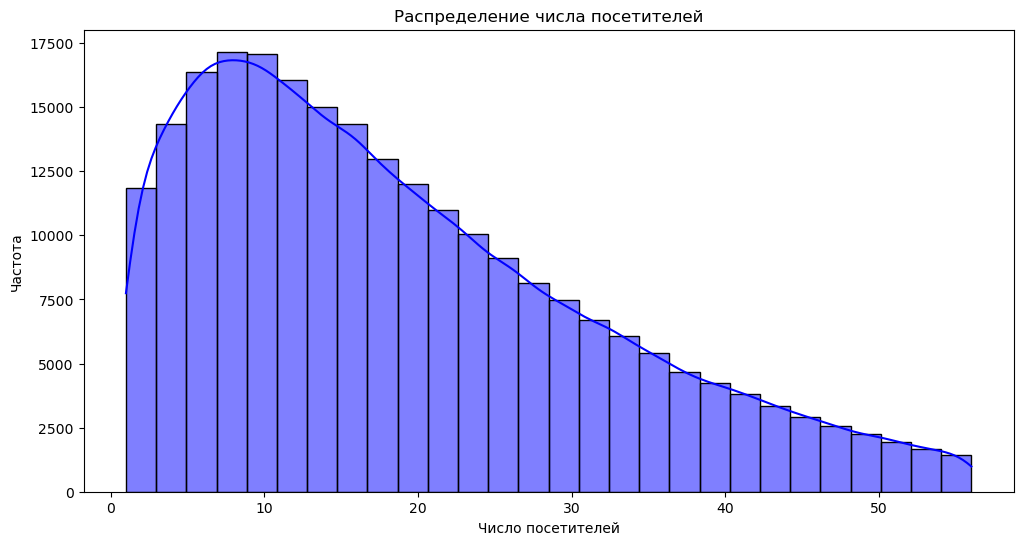

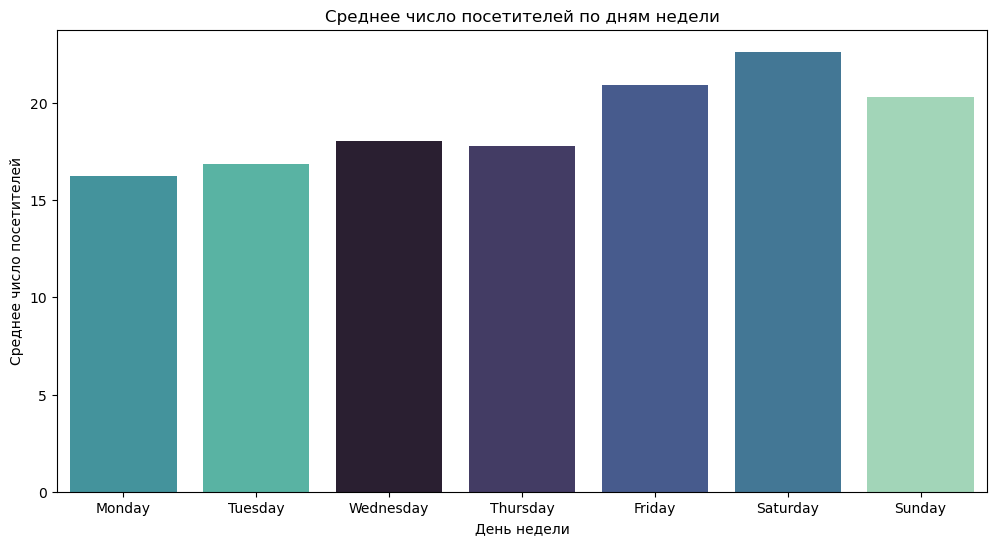

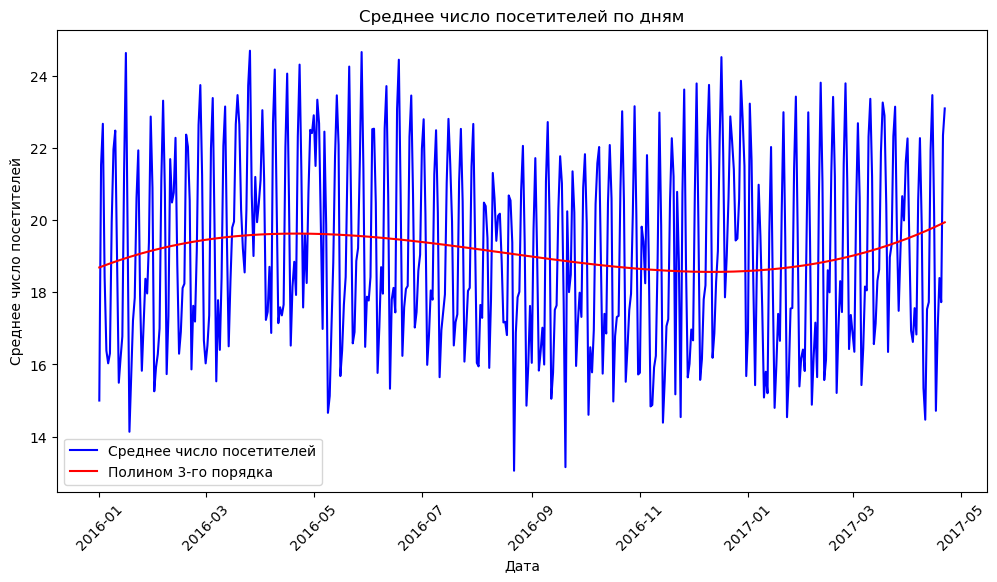

In [18]:
#Графики

# plt.figure(figsize=(12, 6))
# sns.boxplot(x=cleaned_air_visit_data['visitors'])
# plt.show()


plt.figure(figsize=(12, 6))
sns.histplot(cleaned_air_visit_data['visitors'], bins=28, kde=True, color='blue')
plt.title('Распределение числа посетителей')
plt.xlabel('Число посетителей')
plt.ylabel('Частота')
plt.show()


visitors_by_day = cleaned_air_visit_data.groupby('day_of_week', sort=False)['visitors'].mean()
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(12, 6))
sns.barplot(x='day_of_week', y='visitors', data=visitors_by_day.reset_index(), order=days, palette="mako", hue='day_of_week')
plt.title('Среднее число посетителей по дням недели')
plt.xlabel('День недели')
plt.ylabel('Среднее число посетителей')
plt.show()



avg_visitors = cleaned_air_visit_data.groupby('visit_date')['visitors'].mean().reset_index()
avg_X = (avg_visitors['visit_date'] - avg_visitors['visit_date'].min()).dt.days.values.reshape(-1, 1)
avg_y = avg_visitors['visitors']
polynom = PolynomialFeatures(degree=3)
polynom_X = polynom.fit_transform(avg_X)
model = LinearRegression()
model.fit(polynom_X, avg_y)
polynom_pred_y = model.predict(polynom_X)
plt.figure(figsize=(12, 6))
plt.plot(avg_visitors['visit_date'], avg_visitors['visitors'], color='blue', label='Среднее число посетителей')
plt.plot(avg_visitors['visit_date'], polynom_pred_y, color='red', label='Полином 3-го порядка')
plt.title('Среднее число посетителей по дням')
plt.xlabel('Дата')
plt.ylabel('Среднее число посетителей')
plt.legend()
plt.xticks(rotation=45)
plt.show()

Поиск гиперпараметров для модели: Linear Regression
Поиск гиперпараметров для модели: XGBoost
Лучшие гиперпараметры: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.5, 'colsample_bytree': 0.6}
Средние абсолютные ошибки моделей:
XGBoost: MAE = 8.0156, MAPE = 97.87%
Linear Regression: MAE = 9.1255, MAPE = 116.31%
Первые 10 прогнозов посетителей для тестовой выборки:
[10.015032 22.29639  24.097834 27.892422 28.578714 32.806576 12.790775
 10.015032 22.998407 24.072687]


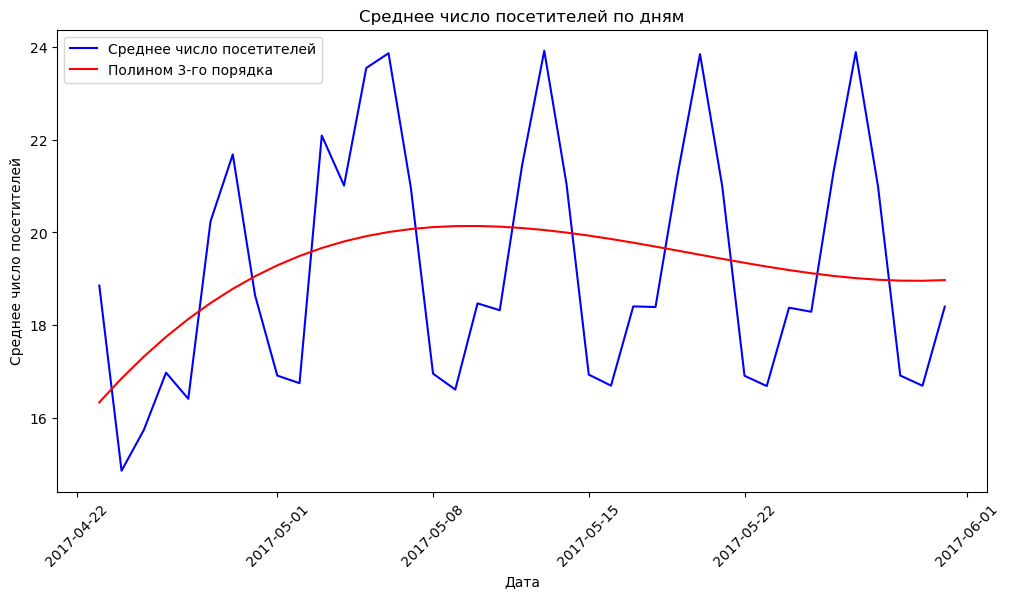

In [20]:
#Признаки для обучения модели
X_train = cleaned_air_visit_data_encoded
#Данные visitors для обучения модели
y_train = cleaned_air_visit_data['visitors']
#Разбиение выборки на тестовую и обучающую в соотношении 3 к 7
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42
)
# Добавляем необходимый импорт
from sklearn.model_selection import RandomizedSearchCV

# Используем две модели - Линейная регрессия и XGBoost
models = {
    "Linear Regression": LinearRegression(),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
}

# Задаем гиперпараметры для RandomizedSearchCV
gyper_parameters = {
    "Linear Regression": {},
    "XGBoost": {
        'n_estimators': [100, 200, 300, 400],
        'learning_rate': [0.01, 0.1, 0.3, 0.5],
        'max_depth': [3, 5, 7, 9],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
    }
}

# Результаты
model_scores = {}
mape_scores = {}

for name, model in models.items():
    print(f'Поиск гиперпараметров для модели: {name}')

    if gyper_parameters[name]:
        # Используем RandomizedSearchCV только для XGBoost
        if name == "XGBoost":
            random_search = RandomizedSearchCV(
                estimator=model,
                param_distributions=gyper_parameters[name],
                n_iter=50,
                scoring='neg_mean_absolute_error',
                cv=5,
                random_state=42,
                n_jobs=-1
            )
            random_search.fit(X_train_split, y_train_split)
            print(f"Лучшие гиперпараметры: {random_search.best_params_}")
            best_model = random_search.best_estimator_
        else:
            # Для других моделей (если потребуется)
            grid_search = GridSearchCV(model, gyper_parameters[name])
            grid_search.fit(X_train_split, y_train_split)
            best_model = grid_search.best_estimator_

        y_val_pred = best_model.predict(X_val_split)
    else:
        model.fit(X_train_split, y_train_split)
        y_val_pred = model.predict(X_val_split)

    mae = mean_absolute_error(y_val_split, y_val_pred)
    mape = mean_absolute_percentage_error(y_val_split, y_val_pred) * 100

    model_scores[name] = mae
    mape_scores[name] = mape
#Сортируем ошибки по возрастанию
sorted_scores = sorted(model_scores.items(), key=lambda x: x[1])

print("Средние абсолютные ошибки моделей:")
for model, score in sorted_scores:
    print(f"{model}: MAE = {score:.4f}, MAPE = {mape_scores[model]:.2f}%")

#Выбираем модель с самой маленькой ошибкой
best_model_name = sorted_scores[0][0]
best_model = models[best_model_name]
#Если у лучшей модели были гиперпараметры, то обновляем best_model
if best_model_name in gyper_parameters and gyper_parameters[best_model_name]:
    best_model = random_search.best_estimator_

#Обучаем лучшую модель на всей обучающей выборке
best_model.fit(X_train, y_train)

#Используем тестовую выборку
X_test = sample_submission_encoded
y_test_pred = best_model.predict(X_test)


print("Первые 10 прогнозов посетителей для тестовой выборки:")
print(y_test_pred[:10])


sample_submission['visitors']=y_test_pred
avg_visitors = sample_submission.groupby('visit_date')['visitors'].mean().reset_index()
avg_X = (avg_visitors['visit_date'] - avg_visitors['visit_date'].min()).dt.days.values.reshape(-1, 1)
avg_y = avg_visitors['visitors']
polynom = PolynomialFeatures(degree=3)
polynom_X = polynom.fit_transform(avg_X)
model = LinearRegression()
model.fit(polynom_X, avg_y)
polynom_pred_y = model.predict(polynom_X)
plt.figure(figsize=(12, 6))
plt.plot(avg_visitors['visit_date'], avg_visitors['visitors'], color='blue', label='Среднее число посетителей')
plt.plot(avg_visitors['visit_date'], polynom_pred_y, color='red', label='Полином 3-го порядка')
plt.title('Среднее число посетителей по дням')
plt.xlabel('Дата')
plt.ylabel('Среднее число посетителей')
plt.legend()
plt.xticks(rotation=45)
plt.show()